# Introduction

This notebook is the third in the Makemore series. In part 2, we implemented a character-level language model using the MLP described in [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). Our goal, is to graduate to a more complex neural networks such as an RNN with its variations (GRUs, LSTMs). But for this third part of the tutorial, Andrej decided to have us stick around MLPs for a bit longer. Why? **To get a deep and intuitive understanding of the activations in the neural network during training, and especially the gradients that are flowing backward, how they behave, and what they look like**. 

This understanding, Andrej said, is instrumental in understanding the development of architectures such as the RNN, and its variants. While Recurrent Neural Networks (RNNs) very expressive and a "general" approximator and can in theory implement all the algorithms, Andrej said that will see they are not easily optimizable using the gradient-based techniques we used so far. And the key reason why has to do with the activations, the gradients and how they behave during training. A lot of the variants since the original RNN, Andrej said, have tried to improve this situation.

That is the path Andrej would like us to take, and I am ready for it. Let's do this!

# Starter code

The code we set out to use in this part is very similar to what we used in `part-2`, but Andrej cleaned it up a little bit. So, I am copying his version of the code.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# Split into train, dev, and test sets
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embeding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed),              generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden),  generator=g)
b1 = torch.randn(n_hidden,                          generator=g)
W2 = torch.randn((n_hidden, vocab_size),            generator=g)
b2 = torch.randn(vocab_size,                        generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [7]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a white (multiple)
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.8263
  20000/ 200000: 2.5130
  30000/ 200000: 2.8010
  40000/ 200000: 2.0541
  50000/ 200000: 2.6152
  60000/ 200000: 2.3549
  70000/ 200000: 2.0835
  80000/ 200000: 2.2652
  90000/ 200000: 2.2635
 100000/ 200000: 2.0810
 110000/ 200000: 2.3367
 120000/ 200000: 1.9650
 130000/ 200000: 2.4398
 140000/ 200000: 2.1524
 150000/ 200000: 2.1201
 160000/ 200000: 2.0399
 170000/ 200000: 1.8172
 180000/ 200000: 2.0771
 190000/ 200000: 1.7632


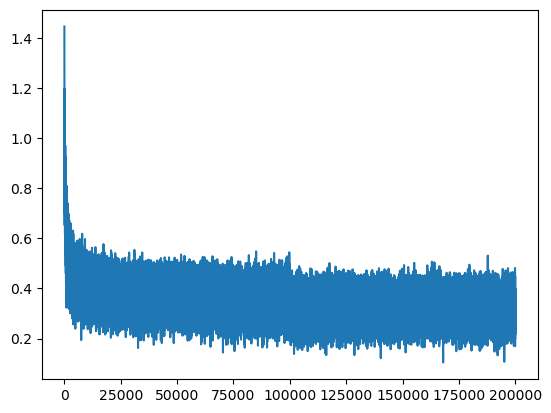

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.1261181831359863
val 2.1693320274353027


In [10]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with "..."
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift context window and incorporates the previously made prediction, "ix"
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carlah.
amorie.
khi.
myli.
taty.
salayson.
mahnen.
den.
art.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wazthoniearynix.
kaelissuli.


# Fixing the initial loss

With our starting code written, the first thing Andrej brought up was the **initialization**. Our network, he said, is improperly initialized for several reasons. While looking at the following:

```
 0/ 200000: 27.8817
  10000/ 200000: 2.8263
  20000/ 200000: 2.5130
  30000/ 200000: 2.8010
  40000/ 200000: 2.0541
  50000/ 200000: 2.6152
  60000/ 200000: 2.3549
  70000/ 200000: 2.0835
  80000/ 200000: 2.2652
  90000/ 200000: 2.2635
 100000/ 200000: 2.0810
 110000/ 200000: 2.3367
 120000/ 200000: 1.9650
 130000/ 200000: 2.4398
 140000/ 200000: 2.1524
 150000/ 200000: 2.1201
 160000/ 200000: 2.0399
 170000/ 200000: 1.8172
 180000/ 200000: 2.0771
 190000/ 200000: 1.7632
```
On the $0^{th}$ iteration, a loss of $27.8$ was recorded. This loss rapidly falls to $2$, and then later goes to $1$. This rapid fall, Andrej pointed out, reveals that the weights' initialization is messed up. In training of neural nets, he continued, it is almost always the case to have an idea of what loss to expect at initialization, and that depends on the loss function and the problem setup.

In our case, Andrej did not expect $27$ as a loss, but rather smaller number that we'll soon calculate together.

At initialization, Andrej said, there are $27$ possible characters that could come next for any training example. At such an early stage, however, we have no reason to believe that one character is more likely than another. As a result, we'd expect the probability distribution coming out of the network to be uniform, effectively assigning the same probability to the $27$ characters. In other words, we'd expect that the probabilities be equal or close to $\frac{1}{27}$, at initialization. And the loss should be:

In [11]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

This is the loss value to be expected at initialization, $3.2958$. It is much lower than the $27$ we got earlier. What is happening is that at initialization the neural net produces probability distributions that are all "messed up" (the term Andrej used). The network assigns a very high probability to certain characters, while assigning a very low probability to others. The network is very confidently wrong. Thus resulting a very high loss.

To further illustrate this, Andrej proposed to consider 4-dimensional example of the issue.

In [12]:
# 4-dimensional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
#logits = torch.randn(4) # randomly pick 4 logits out of a normal distribution
#logits = torch.randn(4) # randomly pick 4 extreme logits
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In the scenario where we have only 4 characters, so four possible predictions, and _we have logits coming out of the neural network that are very close to zero_. Taking the softmax results in a uniform (i.e. difused ) probability distribution. If the correct label is, say $2$, then the loss is given by `-probs[2].log()` which is equal to $1.3863$. It is low, right?

So, if by "chance", at initialization the network assigns a high probability to the correct label, then the resulting loss will be low. Conversely, if the network assigns a high probability to the wrong label, then the resulting loss will be high. To illustrate this, Andrej randomly picked four logits out of a normal distribution (so somewhat close to zero) and the resulting was low... when he picked some extreme logit values, the resulting loss was much higher. Try playing around with the values in the `logits` tensor and see how it affects the loss.

All of that to say: **We want the network to be output a somewhat uniform probability distribution at initialization. In other words, we want the network to produce somewhat equal logits (zeroes) at initialization**.

The reason why we acheive a high loss on the first iteration like we saw is because the logits the network produced are extreme, and the network assigns a high probability to the wrong label. So, the million dollar question is:

> How do we initialized the network weights such that logits come out closer to zero?

First, the logits of the network are calculated by matrix-multiplying the hidden state `h` with `w2`, and then adding the bias `b2`. `b2` is initialized with random numbers, but because we want to be close to zero a set of random biases is undesirable. So, we scale `b2` with zero instead, to ensure that initialization the tensor contains only zeroes.

Second, we want to make `w2` as well. So we also scale down the matrix by `0.01`. Andrej said it is undesirable to initialize weight matrices to zero, and said he will show us why a little later.

With all those changes the new neural network looks like this:

In [13]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embeding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed),              generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden),  generator=g)
b1 = torch.randn(n_hidden,                          generator=g)
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01 # NOT ZERO
b2 = torch.randn(vocab_size,                        generator=g) * 0 # ZERO

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [14]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a white (multiple)
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8645
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


Right of the bat, we can see that the loss at the $0^{th}$ is much closer to our calculation $\frac{1}{27}$. We get a loss of $3.3221$, which is a better starting point. Similarly, the loss plot, no longer has this "hockey" shape appearance. 

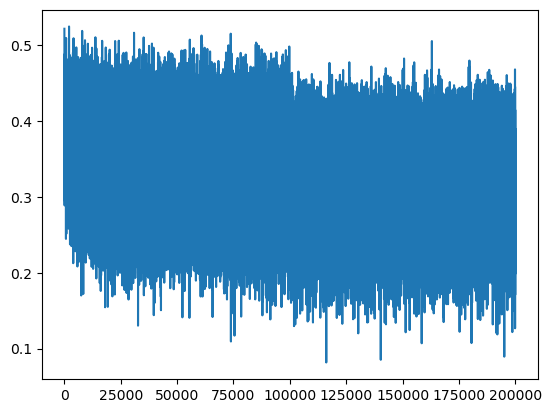

In [15]:
plt.plot(lossi)

When the loss had that "hockey" shape appearance, Andrej said, the optimization first **squashed the logits near ZERO**, then **re-arrange the logits** towards right predictions. In other words, during optimization the weights are updated such that the network start producing logits that are closer to zero. And like we saw earlier, this is desirable.

So, by initiliazing the `b2` and `W2` to zero, and something close to zeros, we skip the easy gains observed at the beginning of training like before. Instead, we are getting the hard gains of the actual training of the neural net. For this reason, we no longer see this "hockey" stick appearance, but rather something that is decreasing veryyy slowly.

Now, two good things are now happening according to Andrej:

1. Loss at initialization is close to what we expect.

2. The loss curve no longer looks like a hockey stick

**NOTE: This is something to look out for, for ANY neural network we might train**

# Fixing the saturated `tanh`

Fixing the initial loss, and the loss curve was the first problem. Now, we are looking at the second problem. This problem, Andrej said, is deeper lurking in the neural network. So, this is something I should pay attention to.

The logits are now okay, but the problem is now on the values of `h`, the tensor containing the activations of the hidden layer. Let's display the values in this tensor.

In [16]:
h

tensor([[ 0.7100, -0.7878, -0.7424,  ..., -1.0000,  1.0000,  1.0000],
        [-0.5614, -1.0000, -1.0000,  ..., -0.8078,  0.9971, -0.9209],
        [-1.0000,  0.9940, -1.0000,  ...,  0.3851, -0.9303,  0.3262],
        ...,
        [-0.9992, -1.0000, -0.9999,  ..., -0.4351, -0.8976, -0.3768],
        [ 0.9939,  0.8976,  1.0000,  ..., -0.9538, -1.0000,  0.9987],
        [-1.0000, -0.9995, -1.0000,  ..., -0.6408, -0.8208,  0.5101]],
       grad_fn=<TanhBackward0>)

Though, it is it hard to see... Andrej pointed out that **a lot of activations in the hidden layer are either $1$ or $-1$**. `torch.tanh` he continued is a "squashing" function. It takes a wide range of values and squashes them into the range $(-1, 1)$, and does so smoothly. Following in Andrej footsteps, let's look at the histogram to get a better idea of the distribution of the values inside the tensor.

In [17]:
h.view(-1) # h is (32 x 200). h.view(-1) stretches out the tensor into a 1-D tensor.
h.shape, h.view(-1).shape

(torch.Size([32, 200]), torch.Size([6400]))

(array([2165.,  152.,   94.,   59.,   51.,   49.,   48.,   36.,   35.,
          33.,   42.,   31.,   45.,   30.,   37.,   24.,   17.,   20.,
          20.,   14.,   28.,   17.,   12.,   22.,   34.,   20.,   22.,
          15.,    8.,   26.,   23.,   22.,   24.,   28.,   40.,   15.,
          23.,   36.,   20.,   27.,   21.,   25.,   30.,   53.,   45.,
          64.,   64.,   88.,  115., 2431.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

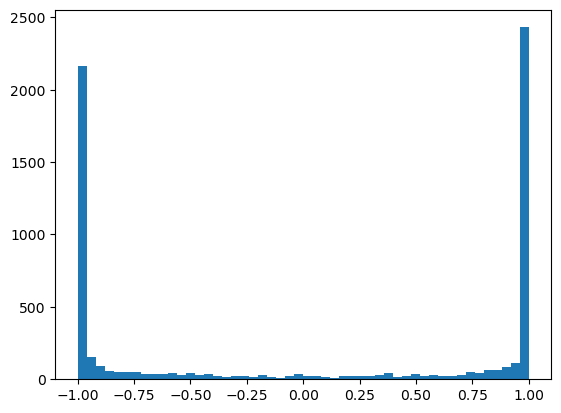

In [18]:
plt.hist(h.view(-1).tolist(), 50) # 50 bins

Looking at the histogram, we can immediately see what Andrej said: *A lot of activations in the hidden layer are either $1$ or $-1$*, and because of that Andrej called the `tanh` function **very active**. I do not know what that means. But right after, he suggested we look at the preactivation values of the hidden layer; the values that we get before we feed them to the `tanh` function.

(array([  1.,   0.,   0.,   1.,   3.,   0.,   4.,   6.,   8.,  10.,  11.,
         20.,  26.,  51.,  67.,  76., 121., 155., 178., 223., 255., 301.,
        333., 348., 449., 557., 501., 375., 362., 311., 300., 278., 225.,
        215., 166., 106., 111.,  89.,  48.,  35.,  24.,  19.,  17.,   7.,
          3.,   3.,   0.,   0.,   0.,   1.]),
 array([-26.79976654, -25.76174088, -24.72371521, -23.68568954,
        -22.64766388, -21.60963821, -20.57161255, -19.53358688,
        -18.49556122, -17.45753555, -16.41950989, -15.38148422,
        -14.34345856, -13.30543289, -12.26740723, -11.22938156,
        -10.1913559 ,  -9.15333023,  -8.11530457,  -7.0772789 ,
         -6.03925323,  -5.00122757,  -3.9632019 ,  -2.92517624,
         -1.88715057,  -0.84912491,   0.18890076,   1.22692642,
          2.26495209,   3.30297775,   4.34100342,   5.37902908,
          6.41705475,   7.45508041,   8.49310608,   9.53113174,
         10.56915741,  11.60718307,  12.64520874,  13.68323441,
         14.721260

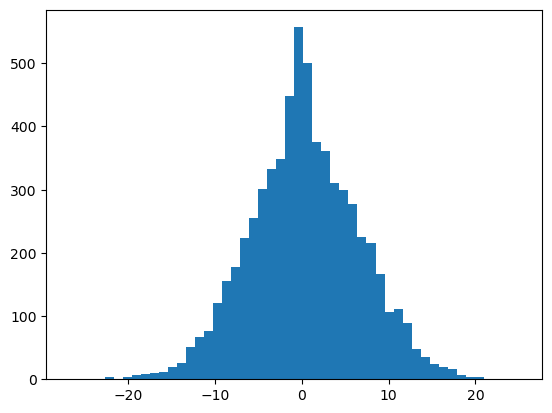

In [19]:
plt.hist(hpreact.view(-1).tolist(), 50) # 50 bins

The distribution of the pre-activations is very broad taking values between $-20$ and $20$. When those values goes through the `tanh` all those values get squashed and caped at $-1$ and $1$.

But coming back and looking at the distribution of `tanh` activations, we can see that we have lots of extreme values. Since I am new to neural nets, I do not see an issue with this observation. But as I continue, I will understand why this is an undesirable scenario.

During backpropagation, we start at the loss and backpropagate through the network. Then we reach the hidden layer that we also have to backpropagate through. This layer contains $200$ neurons for each example. So Andrej suggested we look at what happens during `tanh` during the backward pass. We went back to our code in micrograd, which mine is withing the `Baby steps with PyTorch`, specifically in the `micrograd.ipynb` notebook. The code looked like this

```py
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), _op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
```

When backpropagating through a `tanh` we multiply `out.grad` with the local gradient local gradient `(1 - t**2)`. So, *What happens when the output of our `tanh` is very close to $-1$ or $-1$*? If $t = 1$ for instance, the term `(1 - t**2)` goes to zero... and no matter what `out.grad` is we are "killing" the gradient, and consequently stopping the backpropagation through the `tanh` unit. Same scenario happens when $t = -1$... `out.grad` can longer flow backward. It stops right there.

Andrej continued and said that when the output of a `tanh` neuron is very close to $1$ we are in this fat region of the curve:

[IMAGE HERE]

Thus changing the inputs of this neuron is **not** going to impact the output of this neuron too much since it is located in this flat region. Therefore the loss will likely not change as well. Another way to put this would be that computing the net input of the weights and biases attached to this neuron result in a value so big that passing this value in a $tanh$ function lends us into the flat regions of the $tanh$ curve, and slowly changing those weights and biases attached to the neuron only let us move ever so slightly in the same region. The consquence? Despite those updates, the output of the neuron does not really change. So, those updates essentially have zero effect on the loss. If those updates do not affect the loss, then those updates do not improve the overall performance of our network. That's one way to say *the gradient is basically zero. We say it **"vanishes"***. Let's see at another way to look at it.

When $t = 0$, we get `out.grad`. It means that when the output of the `tanh` unit (i.e. neuron) is exactly zero, then `out.grad` is just passed through... it just flows through the `tanh` unit during backprop. So when $t=0$, it's a bit like the `tanh` unit is "inactive", and the gradient just passes through "unharmed". But the more the output of this `tanh` unit lends in the flat tails of the $tanh$ function, the more the gradient (`out.grad`) is "squashed" (i.e. scaled down). So, Andrej says that _the gradient flowing through `tanh` can only decrease_; and the amount by which it decreases it proportional to this quantity `(1 - t**2)`.

So coming back to our MLP. The concern is if almost all of our activations are in the flat tails on the $tanh$ curve, then the gradient flowing back through the network will get "destroyed".

Andrej gave us this code, to plot a graph that will let us see how often the activations in the `h` tensor are in the flat regions

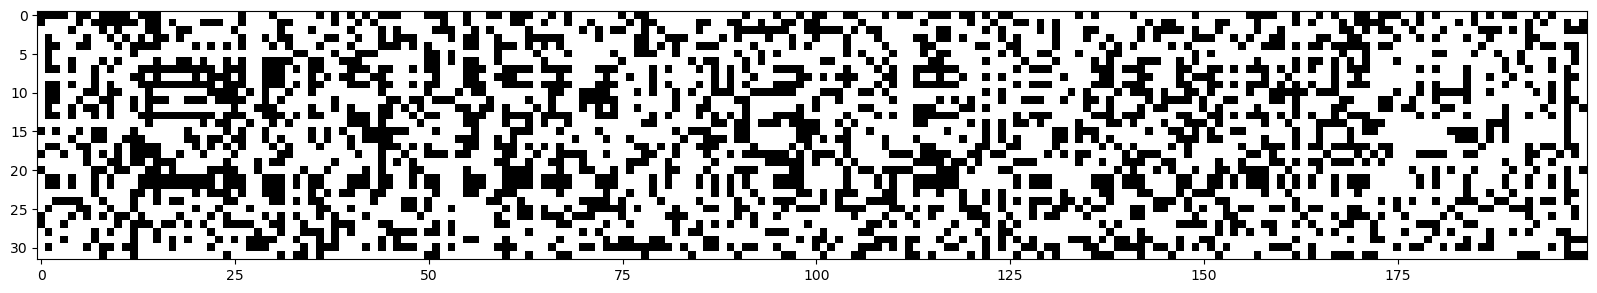

In [20]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

We just printed a boolean tensor. In such tensor, a white represents white is `True` and black is `False`. 32 training examples, and 200 neurons. We can see that a lot of this is white, which means that all those `tanh` neurons were very "active". Thus in all those cases, the backward gradient gets "destroyed". What a waste!

Also, for every one of this $200$ neuron... if it was the case that an entire column was white, it would mean that **all of the examples in this batch lands in one of the tails of the `tanh`**. It might be that the neuron is initialized in such a way that no single example fall in the "okay" part of the $tanh$ curve, but fall in one the tail parts. Such neuron will **never learn**. It is a **dead neuron**. Andrej did not locate a "dead" neuron in our case here, but this an instance I can find myself in... thus information is good. And this information is true not only for $tanh$, but some other non-linearities as well.

Since we do have dead neurons in our 200, it means that _there are_ some examples that activate them in the "okay" part of the $tanh$ curve, which implies some gradients will actually flow through the neuron, and that it will learn from those. But it is not optimal, espcially during iniitialization. So, what is happening the preactivations values in the `hpreact` following through `tanh` are too extreme, they are too large... so printing the `tanh` distribution looks like what we saw, it is too saturated in both sides of the `tanh`. And like we saw this is not something that we want because it means that less training is happening for these neurons.

Enough describing the problem. How do we fix this? We want `hpreact` to be closer to zero. Simple as that. Let's do this. We obtain `hpreact` by using `W1` and `b1`. So, let's bring them closer to zero.

In [21]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embeding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed),              generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden),  generator=g) * 0.1 # SCALE DOWN THE WEIGHTS
b1 = torch.randn(n_hidden,                          generator=g) * 0.01 # TO GET A LITTLE BIT OF ENTROPY (ANDREJ'S RECOMMENDATION)
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [22]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a white (multiple)
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break # stop after first batch

      0/ 200000: 3.3069


(array([  6.,  17.,  20.,  30.,  49.,  61.,  72.,  89.,  87.,  99., 135.,
        121., 153., 134., 138., 140., 174., 163., 179., 184., 138., 196.,
        183., 226., 165., 212., 191., 175., 201., 211., 189., 186., 166.,
        178., 183., 156., 194., 155., 171., 140., 139., 122., 102.,  96.,
         81.,  72.,  41.,  39.,  23.,  18.]),
 array([-0.95476669, -0.91695139, -0.87913609, -0.84132079, -0.80350549,
        -0.76569019, -0.72787489, -0.69005959, -0.65224429, -0.61442899,
        -0.57661369, -0.53879839, -0.50098309, -0.46316779, -0.42535249,
        -0.38753719, -0.34972189, -0.31190659, -0.27409129, -0.23627599,
        -0.19846069, -0.16064539, -0.12283009, -0.08501479, -0.04719949,
        -0.00938419,  0.02843112,  0.06624642,  0.10406172,  0.14187702,
         0.17969232,  0.21750762,  0.25532292,  0.29313822,  0.33095352,
         0.36876882,  0.40658412,  0.44439942,  0.48221472,  0.52003002,
         0.55784532,  0.59566062,  0.63347592,  0.67129122,  0.70910652,
 

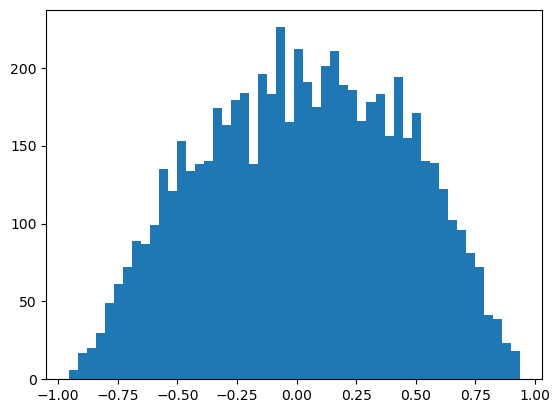

In [23]:
plt.hist(h.view(-1).tolist(), 50) # 50 bins

Since we multiplied `W1` by `0.1`, the distribution of `h` is looking much better. That's because the preactivation values now lies in the $(-1.5, 1.5)$ interval. These values are less extreme compared to what we had before.

(array([  1.,   2.,   0.,   1.,   5.,   3.,  10.,   7.,  12.,  12.,  24.,
         39.,  40.,  76.,  66.,  98., 127., 171., 191., 203., 231., 275.,
        310., 288., 360., 368., 384., 352., 363., 338., 304., 281., 287.,
        229., 207., 166., 137., 101.,  90.,  74.,  46.,  28.,  28.,  21.,
         11.,   8.,  11.,   5.,   2.,   7.]),
 array([-1.88309646, -1.81133983, -1.73958321, -1.66782659, -1.59606997,
        -1.52431334, -1.45255672, -1.3808001 , -1.30904347, -1.23728685,
        -1.16553023, -1.09377361, -1.02201698, -0.95026036, -0.87850374,
        -0.80674711, -0.73499049, -0.66323387, -0.59147725, -0.51972062,
        -0.447964  , -0.37620738, -0.30445076, -0.23269413, -0.16093751,
        -0.08918089, -0.01742426,  0.05433236,  0.12608898,  0.1978456 ,
         0.26960223,  0.34135885,  0.41311547,  0.4848721 ,  0.55662872,
         0.62838534,  0.70014196,  0.77189859,  0.84365521,  0.91541183,
         0.98716846,  1.05892508,  1.1306817 ,  1.20243832,  1.27419495,
 

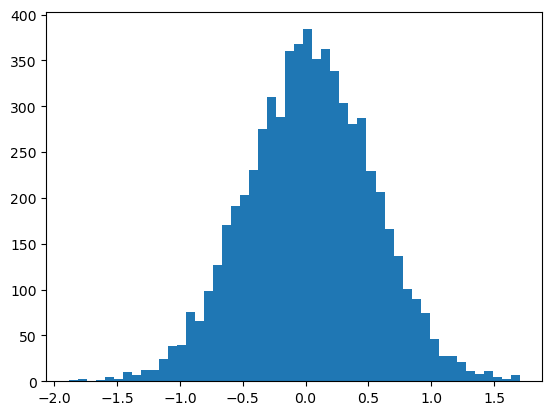

In [24]:
plt.hist(hpreact.view(-1).tolist(), 50) # 50 bins

We can once again printout the black and white matrix like earlier to compare, and this time we'd much much less white appearing:

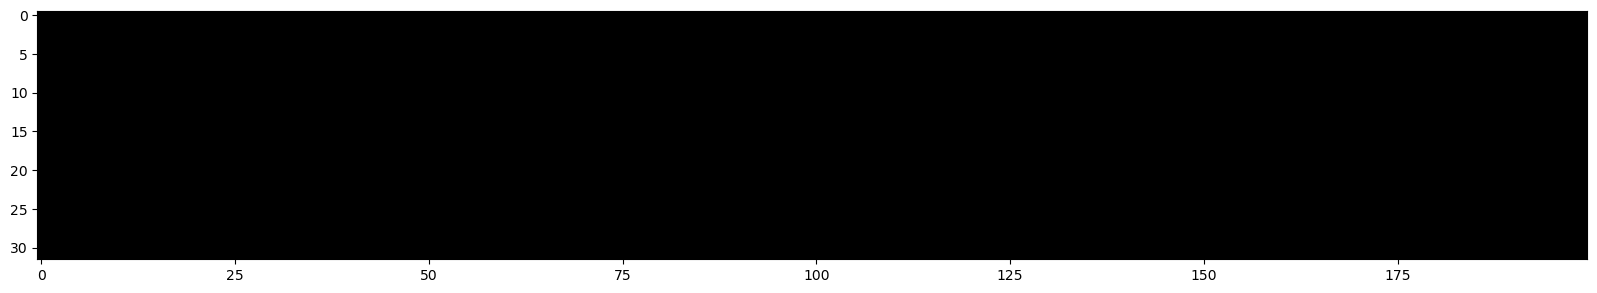

In [25]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

Well, there is no white! Lol. It means that for all examples in this batch, the gradient is able flow through each neurons in the hidden layer. No neurons in the hidden layer saturated above `0.99` in either direction. In other words, all $200$ neurons in the hidden layer are learning something from each example in the batch.

After explaining this Andrej re-initialized and ran the network for the full optimization, not just the first batch.

In [26]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embeding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed),              generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden),  generator=g) * 0.2 # ANDREJ CHANGED THE VALUE
b1 = torch.randn(n_hidden,                          generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [27]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a white (multiple)
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


In [28]:
split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.102678060531616


Compared to the orignal loss values, desaturating the `tanh` resulted in an improvement. It is happening because our initialization is better, so the network spends more time doing "productive" training. All of the things I went through is to illustrate the impact of initialization on performance.

Because we are working with a shallow network (one-layer MLP), Andrej said the optimization problem is easy and very forgiving. so, even though our initialization was trash, the network was able to learn and improv. This, Andrej said, **is not the case in general**. We should see this become more clear as we work our way through bigger and deeper networks. So, I need to be aware and careful.

# Calculating the init scale: "Kaiming init"

Looking back at the manipulation we performed when initializing the network in the previous section:

```py
# MLP revisited
n_embed = 10 # the dimensionality of the character embeding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed),              generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden),  generator=g) * 0.2 # ANDREJ CHANGED THE VALUE
b1 = torch.randn(n_hidden,                          generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0
```

We scaled down that the "weight" and "biases" matrices. But I just copied Andrej; I copied the same value as him. But how did he choose those "magic" numbers (i.e. constants). Plus, how are going to go about this if we have a large neural network with lots of layers? No one does this by hand. There is exist principled ways of setting this scales, and this is what this section is about.